# Loading repository and dataset

In [6]:
# If you want to update repository (re-download)
!rm -r DeepImageInpainting

In [7]:
!git clone https://github.com/Nagim123/DeepImageInpainting.git

Cloning into 'DeepImageInpainting'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 403 (delta 75), reused 95 (delta 40), pack-reused 267
Receiving objects: 100% (403/403), 31.94 MiB | 31.48 MiB/s, done.
Resolving deltas: 100% (221/221), done.


In [8]:
!python DeepImageInpainting/src/data/create_dataset_cifar_10.py

2023-10-23 19:20:54.522553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-23 19:20:54.522623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-23 19:20:54.522663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-23 19:20:54.531544: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 19:20:55.777118: W tensorflow/compiler/

In [9]:
!python DeepImageInpainting/src/data/show_image.py cifar10.pt

Saved to temp/temp.png!


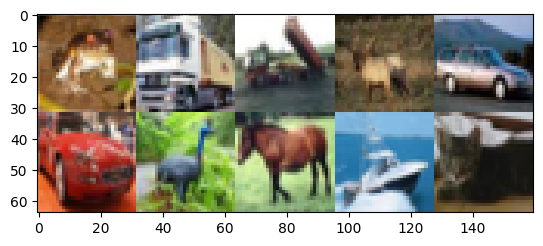

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
plt.imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))

In [11]:
!python DeepImageInpainting/src/data/show_image.py cifar10.pt --masked

Saved to temp/temp.png!


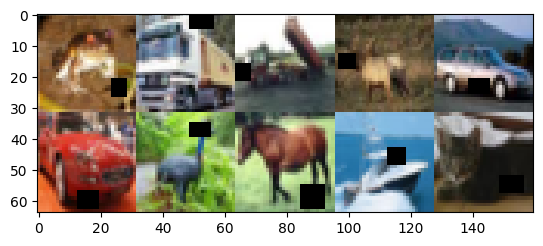

In [12]:
plt.imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))

# Model

In [13]:
import torch
import torch.nn as nn

class VanillaAE(nn.Module):
    def __init__(self):
        super(VanillaAE, self).__init__()
        self.encode_layer = nn.Sequential(
            nn.Conv2d(3, 32, (3,3), (1,1), 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(32, 64, (3,3), (1,1), 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
            nn.Conv2d(64, 128, (3,3), (1,1), 1),
            nn.ReLU(),
            nn.MaxPool2d((2,2)),
        )
        self.hidden_layer = nn.Linear(2048, 1024)
        self.decode_layer = nn.Sequential(
            nn.ConvTranspose2d(64, 32, (2,2), (2,2)),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, (2,2), (2,2)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, (2,2), (2,2)),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x - shape[B, C, H, W]
        x = self.encode_layer(x)
        x = x.view(-1, 2048)
        x = self.hidden_layer(x)
        x = x.view(-1, 64, 4, 4)
        x = self.decode_layer(x)
        return x

In [14]:
model = VanillaAE()
model_scripted = torch.jit.script(model)
model_scripted.save("vanilla_ae.pt")

In [15]:
!python DeepImageInpainting/src/train_model.py vanilla_ae.pt cifar10.pt 20 BCELoss

Epoch: 0
100% 1313/1313 [00:16<00:00, 81.17it/s, loss=0.6] 
100% 563/563 [00:01<00:00, 536.44it/s, e_loss=0.584]
Average train loss:0.5880125100977622 
 Average validation loss:0.572910149609852
Epoch: 1
100% 1313/1313 [00:07<00:00, 171.92it/s, loss=0.594]
100% 563/563 [00:01<00:00, 533.57it/s, e_loss=0.567]
Average train loss:0.5702195281938842 
 Average validation loss:0.5671244315525144
Epoch: 2
100% 1313/1313 [00:06<00:00, 191.94it/s, loss=0.592]
100% 563/563 [00:01<00:00, 502.20it/s, e_loss=0.566]
Average train loss:0.5659009311731227 
 Average validation loss:0.5645848606873575
Epoch: 3
100% 1313/1313 [00:06<00:00, 213.40it/s, loss=0.591]
100% 563/563 [00:01<00:00, 535.22it/s, e_loss=0.562]
Average train loss:0.5638150018494454 
 Average validation loss:0.5631302749708321
Epoch: 4
100% 1313/1313 [00:06<00:00, 187.60it/s, loss=0.589]
100% 563/563 [00:01<00:00, 533.26it/s, e_loss=0.573]
Average train loss:0.5624954116226423 
 Average validation loss:0.5621775683035436
Epoch: 5
100%

# Test

## On seen data

In [16]:
!python DeepImageInpainting/src/predict_model.py vanilla_ae.pt DeepImageInpainting/src/models/best_weights.pt --dataset cifar10.pt --image_index 0
!python DeepImageInpainting/src/data/show_image.py cifar10.pt --image_index 0 --masked

Saved to temp/temp.png!


<Figure size 640x480 with 0 Axes>

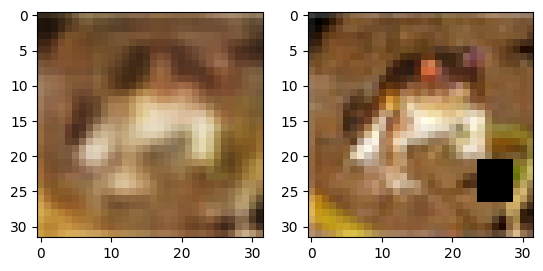

In [17]:
plt.figure()

f, axarr = plt.subplots(1,2)

axarr[0].imshow(Image.open('prediction.png'))
axarr[1].imshow(Image.open('DeepImageInpainting/src/data/temp/temp.png'))

## On unseend data

In [18]:
!python DeepImageInpainting/src/predict_model.py vanilla_ae.pt DeepImageInpainting/src/models/best_weights.pt --dataset cifar10.pt --image_path DeepImageInpainting/src/data/unseen/plane_1_masked.png

<Figure size 640x480 with 0 Axes>

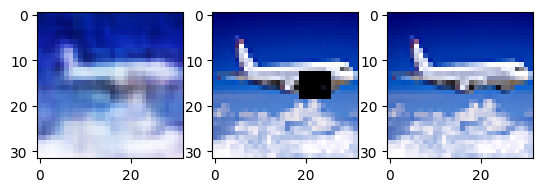

In [19]:
plt.figure()

f, axarr = plt.subplots(1,3)

axarr[0].imshow(Image.open('prediction.png'))
axarr[1].imshow(Image.open('DeepImageInpainting/src/data/unseen/plane_1_masked.png'))
axarr[2].imshow(Image.open('DeepImageInpainting/src/data/unseen/plane_1.png'))